<a href="https://colab.research.google.com/github/pongsapaks/Detection-depression/blob/main/BERT_detecting_depression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.9 MB/s eta 0:00:00


In [3]:
#importing the libraries
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
import os
import re
import glob

import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.graph_objs as go
import itertools
from scipy import stats
from ast import literal_eval
import spacy
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
import gensim
import json
import pickle

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model   #from keras.utils.vis_utils import plot_model
import keras.utils
from keras import utils as np_utils

#Keras Tokenizer just replaces certain punctuation characters and splits on the remaining space character.
#NLTK Tokenizer uses the Treebank tokenizer uses regular expressions to tokenize text as in Penn Treebank.

In [5]:
#WINDOWS_SIZE = 10
labels=['no','yes']
num_classes = len(labels)

In [61]:
#converting the transcript files into a dataframe
def transcripts_to_dataframe(directory):
    rows_list = []
    folders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    folders = sorted(folders)
    for folder in folders:
      folder_path = os.path.join(directory, folder)
      filenames = [f for f in os.listdir(folder_path) if f.lower().endswith('.csv')]

      if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")

      for filename in filenames:
        transcript_path = os.path.join(folder_path, filename)
        transcript = pd.read_csv(transcript_path,encoding='utf-8', sep='\t')
        m = re.search("(\d{3})_TRANSCRIPT.csv", filename)
        if m:
            person_id = m.group(1)
            p = {}
            question = ""
            answer = ""
            lines = len(transcript)
            for i in range(0, lines):
                row = transcript.iloc[i]
                if (row["speaker"] == "Ellie") or (i == lines - 1):
                    p["personId"] = person_id
                    if "(" in str(question):
                        question = question[question.index("(") + 1:question.index(")")]
                    p["question"] = question
                    p["answer"] = answer
                    if question != "":
                        rows_list.append(p)
                    p = {}
                    answer = ""
                    question = row["value"]
                else:
                    answer = str(answer) + " " + str(row["value"])

    all_participants = pd.DataFrame(rows_list, columns=['personId', 'question', 'answer'])
    #all_participants = all_participants.sort_values(by= 'personId').reset_index(drop=True)
    all_participants.to_csv("/content/drive/MyDrive/Final_DLP/" + 'all.csv', sep=',', index=False)
    print("File was created")
    return all_participants

In [62]:
data_path = "/content/drive/MyDrive/Final_DLP/data/"
all_participants = transcripts_to_dataframe(data_path)

File was created


In [70]:
 all_participants = pd.read_csv("/content/drive/MyDrive/Final_DLP/all.csv")
 all_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14903 entries, 0 to 14902
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   personId  14903 non-null  int64 
 1   question  14902 non-null  object
 2   answer    10468 non-null  object
dtypes: int64(1), object(2)
memory usage: 349.4+ KB


In [82]:
display(all_participants)

,personId,question,answer
0,300,hi i'm ellie thanks for coming in today,NaN
1,300,i was created to talk to people in a safe and ...,NaN
2,300,think of me as a friend i don't judge i can't ...,NaN
3,300,i'm here to learn about people and would love ...,NaN
4,300,i'll ask a few questions to get us started and...,NaN
...,...,...,...
14898,492,mm,NaN
14899,492,what are you most proud of in your life,um i am very proud of the fact that uh i don'...
14900,492,okay i think i have asked everything i need to,NaN
14901,492,thanks for sharing your thoughts with me,NaN


In [83]:
#Selecting the data from the data from based on the questions asked  ['where', 'when', 'how', 'why', 'are', 'what', 'do', 'have', 'can', 'did', 'is', 'could', 'so', 'tell', 'who', 'has']
interrogative = ["where", "when", "how","why","are","what","do","have","can","did","is", "could", "so", "tell", "who", "has"]
rslt_df = all_participants[all_participants.question.str.contains('|'.join(interrogative),na=False)]
rslt_df['answer'].replace('', np.nan, inplace=True)
rslt_df.dropna(subset = ["answer"], inplace=True)
rslt_df.reset_index(drop=True, inplace=True)
rslt_df
rslt_df = rslt_df.to_csv("/content/drive/MyDrive/Final_DLP/rslt_df.csv" , index=False)

<ipython-input-83-e591d3c236c7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rslt_df['answer'].replace('', np.nan, inplace=True)
<ipython-input-83-e591d3c236c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rslt_df.dropna(subset = ["answer"], inplace=True)


In [84]:
rslt_df = pd.read_csv("/content/drive/MyDrive/Final_DLP/rslt_df.csv")
rslt_df['question']= rslt_df.apply(lambda row: "{0}?".format(row.question), axis=1)
rslt_df

,personId,question,answer
0,300,how are you doing today?,good
1,300,where are you from originally?,atlanta georgia
2,300,why'd you move to l_a?,um my parents are from here um
3,300,how do you like l_a?,i love it
4,300,what are some things you really like about l_a?,i like the weather i like the opportunities u...
...,...,...,...
8661,492,how would your best friend describe you?,that uh i'm smart they would say that i'm sma...
8662,492,what are some things you wish you could change...,um i don't wanna change anything i do want to...
8663,492,is there anything you regret?,no
8664,492,what advice would you give to yourself ten or ...,mm that's a good question i would have uh i w...


In [85]:
rslt_df['statements'] = rslt_df[['question', 'answer']].agg(':'.join, axis=1)
rslt_df

,personId,question,answer,statements
0,300,how are you doing today?,good,how are you doing today?: good
1,300,where are you from originally?,atlanta georgia,where are you from originally?: atlanta georgia
2,300,why'd you move to l_a?,um my parents are from here um,why'd you move to l_a?: um my parents are from...
3,300,how do you like l_a?,i love it,how do you like l_a?: i love it
4,300,what are some things you really like about l_a?,i like the weather i like the opportunities u...,what are some things you really like about l_a...
...,...,...,...,...
8661,492,how would your best friend describe you?,that uh i'm smart they would say that i'm sma...,how would your best friend describe you?: that...
8662,492,what are some things you wish you could change...,um i don't wanna change anything i do want to...,what are some things you wish you could change...
8663,492,is there anything you regret?,no,is there anything you regret?: no
8664,492,what advice would you give to yourself ten or ...,mm that's a good question i would have uh i w...,what advice would you give to yourself ten or ...


In [86]:
rslt_df_concat = rslt_df.groupby('personId').agg({'answer': ' '.join,'statements': ' '.join},).reset_index()
rslt_df_concat

,personId,answer,statements
0,300,good atlanta georgia um my parents are from...,how are you doing today?: good where are you f...
1,301,mmm k i'm doing good thank you i'm from los...,think of me as a friend i don't judge i can't ...
2,302,i'm fine how about yourself i'm from los an...,how are you doing today?: i'm fine how about y...
3,303,okay how 'bout yourself here in california ...,how are you doing today?: okay how 'bout yours...
4,304,i'm doing good um from los angeles californi...,how are you doing today?: i'm doing good um wh...
...,...,...,...
180,488,yes fine oh san fernando valley uh well i ...,hi i'm ellie thanks for coming in today i was ...
181,489,yes i'm doing well thank you san luis obisp...,hi i'm ellie thanks for coming in today i was ...
182,490,yeah i'm doing already how are you doing no...,hi i'm ellie thanks for coming in today i was ...
183,491,yes huh overwhelmed i have a funeral to att...,hi i'm ellie thanks for coming in today i was ...


In [87]:
def load_avec_dataset_file(path,score_column):
    ds = pd.read_csv(path, sep=',')
    ds['level'] = pd.cut(ds[score_column], bins=[-1,9,25], labels=[0,1])  #cut function used to segregate array into bins 2 levels - 'no','yes' using a PHQ score greater than or equal 10.
    ds['cat_level'] = keras.utils.to_categorical(ds['level'], num_classes).tolist() #categorical levels
    ds['PHQ8_Score'] = ds[score_column]
    ds = ds[['Participant_ID', 'level', 'cat_level', 'PHQ8_Score']]
    ds = ds.astype({"Participant_ID": int, "level": int, 'PHQ8_Score': int})
    return ds

In [88]:
train = load_avec_dataset_file('/content/drive/MyDrive/Final_DLP/data/Label/train_split_Depression_AVEC2017.csv','PHQ8_Score')
dev = load_avec_dataset_file('/content/drive/MyDrive/Final_DLP/data/Label/dev_split_Depression_AVEC2017.csv','PHQ8_Score')
test = load_avec_dataset_file('/content/drive/MyDrive/Final_DLP/data/Label/full_test_split.csv','PHQ_Score')
print("Size: train= {}, dev= {}, test= {}".format(len(train), len(dev), len(test)))
test.head(20)

Size: train= 107, dev= 35, test= 47


,Participant_ID,level,cat_level,PHQ8_Score
0,300,0,"[1.0, 0.0]",2
1,301,0,"[1.0, 0.0]",3
2,306,0,"[1.0, 0.0]",0
3,308,1,"[0.0, 1.0]",22
4,309,1,"[0.0, 1.0]",15
5,311,1,"[0.0, 1.0]",21
6,314,0,"[1.0, 0.0]",1
7,323,0,"[1.0, 0.0]",1
8,329,0,"[1.0, 0.0]",1
9,332,1,"[0.0, 1.0]",18


In [89]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Participant_ID  47 non-null     int64 
 1   level           47 non-null     int64 
 2   cat_level       47 non-null     object
 3   PHQ8_Score      47 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.6+ KB


In [90]:
train_lp = train.merge(rslt_df_concat, left_on = train.Participant_ID.astype(int), right_on=rslt_df_concat.personId.astype(int))
test_lp = test.merge(rslt_df_concat, left_on = test.Participant_ID.astype(int), right_on=rslt_df_concat.personId.astype(int))
dev_lp = dev.merge(rslt_df_concat,left_on=dev.Participant_ID.astype(int).astype(int), right_on=rslt_df_concat.personId.astype(int))


In [91]:
train_lp.head()

,key_0,Participant_ID,level,cat_level,PHQ8_Score,personId,answer,statements
0,303,303,0,"[1.0, 0.0]",0,303,okay how 'bout yourself here in california ...,how are you doing today?: okay how 'bout yours...
1,304,304,0,"[1.0, 0.0]",6,304,i'm doing good um from los angeles californi...,how are you doing today?: i'm doing good um wh...
2,305,305,0,"[1.0, 0.0]",7,305,i'm doing alright uh originally i'm from cal...,how are you doing today?: i'm doing alright wh...
3,310,310,0,"[1.0, 0.0]",4,310,yes it's okay <laughter> fine <laughter> i ...,are you okay with this?: yes it's okay so how ...
4,312,312,0,"[1.0, 0.0]",2,312,yes fine how about you here the weather we...,are you okay with this?: yes so how are you do...


In [92]:
print(len(train_lp),len(test_lp) ,len(dev_lp))

107 46 32


In [ ]:
#Check removed personid data due to without interveiwer
merged_df = test.merge(rslt_df_concat, left_on = test.Participant_ID.astype(int), right_on=rslt_df_concat.personId.astype(int), how='left', indicator=True)
merged_df

In [93]:
train_lp = train_lp.sample(frac=1).reset_index(drop=True)
test_lp=test_lp.sample(frac=1).reset_index(drop=True)
dev_lp=dev_lp.sample(frac=1).reset_index(drop=True)

# Re-split Train, Test, Dev

In [1]:
'''
ds_total = pd.concat([train,dev,test],sort=True)
total_phq8 = len(ds_total)
print("Total size = {}".format(total_phq8))

'''

'\nds_total = pd.concat([train,dev,test],sort=True)\ntotal_phq8 = len(ds_total)\nprint("Total size = {}".format(total_phq8))\n\n'

In [2]:
'''
ds_total

'''

'\nds_total\n\n'

In [3]:
'''
len(ds_total)
'''

'\nlen(ds_total)\n'

In [4]:
'''
def split_by_phq_level(ds):
    none_ds = ds[ds['level']==0]
    mild_ds = ds[ds['level']==1]
    moderate_ds = ds[ds['level']==2]
    moderate_severe_ds = ds[ds['level']==3]
    severe_ds = ds[ds['level']==4]
    return (none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds)
'''

"\ndef split_by_phq_level(ds):\n    none_ds = ds[ds['level']==0]\n    mild_ds = ds[ds['level']==1]\n    moderate_ds = ds[ds['level']==2]\n    moderate_severe_ds = ds[ds['level']==3]\n    severe_ds = ds[ds['level']==4]\n    return (none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds)\n"

In [5]:
'''
none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_total)
print("Quantity per none_ds: {}, mild_ds: {}, moderate_ds {}, moderate_severe_ds: {}, severe_ds {}".format(len(none_ds), len(mild_ds), len(moderate_ds), len(moderate_severe_ds), len(severe_ds)))
'''

'\nnone_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_total)\nprint("Quantity per none_ds: {}, mild_ds: {}, moderate_ds {}, moderate_severe_ds: {}, severe_ds {}".format(len(none_ds), len(mild_ds), len(moderate_ds), len(moderate_severe_ds), len(severe_ds)))\n'

In [6]:
'''
b_none_ds = ds_total[ds_total['level']==0]
b_mild_ds = ds_total[ds_total['level']==1].sample(26)
b_moderate_ds = ds_total[ds_total['level']==2].sample(26)
b_moderate_severe_ds = ds_total[ds_total['level']==3]
b_severe_ds = ds_total[ds_total['level']==4]

ds_total_b = pd.concat([b_none_ds, b_mild_ds, b_moderate_ds, b_moderate_severe_ds, b_severe_ds])
ds_total_b

'''

"\nb_none_ds = ds_total[ds_total['level']==0]\nb_mild_ds = ds_total[ds_total['level']==1].sample(26)\nb_moderate_ds = ds_total[ds_total['level']==2].sample(26)\nb_moderate_severe_ds = ds_total[ds_total['level']==3]\nb_severe_ds = ds_total[ds_total['level']==4]\n\nds_total_b = pd.concat([b_none_ds, b_mild_ds, b_moderate_ds, b_moderate_severe_ds, b_severe_ds])\nds_total_b\n\n"

In [7]:
'''
len(ds_total_b)
'''

'\nlen(ds_total_b)\n'

In [8]:
'''
ds_lp = ds_total.merge(rslt_df,left_on=ds_total.Participant_ID.astype(int), right_on=rslt_df.personId.astype(int))
ds_lp_b = ds_total_b.merge(rslt_df,left_on=ds_total_b.Participant_ID.astype(int).astype(int), right_on=rslt_df.personId.astype(int))
len(ds_lp)

'''

'\nds_lp = ds_total.merge(rslt_df,left_on=ds_total.Participant_ID.astype(int), right_on=rslt_df.personId.astype(int))\nds_lp_b = ds_total_b.merge(rslt_df,left_on=ds_total_b.Participant_ID.astype(int).astype(int), right_on=rslt_df.personId.astype(int))\nlen(ds_lp)\n\n'

In [9]:
'''
len(ds_lp)
'''

'\nlen(ds_lp)\n'

In [10]:
'''
def distribute_instances(ds, split_in = [70,14,16]):
    ds_shuffled = ds.sample(frac=1)
    none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_shuffled)
    eq_ds = dict()
    prev_none = prev_mild = prev_moderate = prev_moderate_severe = prev_severe = 0
    split = split_in
    for p in split:
        last_none = min(len(none_ds), prev_none + round(len(none_ds) * p/100))
        last_mild = min(len(mild_ds), prev_mild + round(len(mild_ds) * p/100))
        last_moderate = min(len(moderate_ds), prev_moderate + round(len(moderate_ds) * p/100))
        last_moderate_severe = min(len(moderate_severe_ds), prev_moderate_severe + round(len(moderate_severe_ds) * p/100))
        last_severe = min(len(severe_ds), prev_severe + round(len(severe_ds) * p/100))
        eq_ds['d'+str(p)] = pd.concat([none_ds[prev_none: last_none], mild_ds[prev_mild: last_mild], moderate_ds[prev_moderate: last_moderate], moderate_severe_ds[prev_moderate_severe: last_moderate_severe], severe_ds[prev_severe: last_severe]])
        prev_none = last_none
        prev_mild = last_mild
        prev_moderate = last_moderate
        prev_moderate_severe = last_moderate_severe
        prev_severe = last_severe
    return (eq_ds['d70'], eq_ds['d14'], eq_ds['d16'])

'''

"\ndef distribute_instances(ds, split_in = [70,14,16]):\n    ds_shuffled = ds.sample(frac=1)\n    none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_shuffled)\n    eq_ds = dict()\n    prev_none = prev_mild = prev_moderate = prev_moderate_severe = prev_severe = 0\n    split = split_in\n    for p in split:\n        last_none = min(len(none_ds), prev_none + round(len(none_ds) * p/100))\n        last_mild = min(len(mild_ds), prev_mild + round(len(mild_ds) * p/100))\n        last_moderate = min(len(moderate_ds), prev_moderate + round(len(moderate_ds) * p/100))\n        last_moderate_severe = min(len(moderate_severe_ds), prev_moderate_severe + round(len(moderate_severe_ds) * p/100))\n        last_severe = min(len(severe_ds), prev_severe + round(len(severe_ds) * p/100))\n        eq_ds['d'+str(p)] = pd.concat([none_ds[prev_none: last_none], mild_ds[prev_mild: last_mild], moderate_ds[prev_moderate: last_moderate], moderate_severe_ds[prev_moderate_severe: last_m

In [11]:
'''
train_lp, dev_lp, test_lp = distribute_instances(ds_lp)
#train_lp_b, dev_lp_b, test_lp_b = distribute_instances(ds_lp_b)
'''

'\ntrain_lp, dev_lp, test_lp = distribute_instances(ds_lp)\n#train_lp_b, dev_lp_b, test_lp_b = distribute_instances(ds_lp_b)\n'

In [12]:
'''
train_lp = train_lp.sample(frac=1).reset_index(drop=True)
test_lp=test_lp.sample(frac=1).reset_index(drop=True)
dev_lp=dev_lp.sample(frac=1).reset_index(drop=True)
'''

'\ntrain_lp = train_lp.sample(frac=1).reset_index(drop=True)\ntest_lp=test_lp.sample(frac=1).reset_index(drop=True)\ndev_lp=dev_lp.sample(frac=1).reset_index(drop=True)\n'

# BERT Model

In [ ]:
#BERT model

In [95]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub


In [96]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [97]:
pip install bert-for-tf2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30509 sha256=0ec94c1dc02a988e4d49965f2fcbf2603659ca2763dc5ee27b6e85134d6977d5
  Stored in directory: /root/.cache/pip/wheels/d8/da/50/126d7b8416d9a0e6bf876935c2219a71e72a6529c25e150c56
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19454 sha256=ee19ec14f50bd2d0029726b153fbbaa015deb65c6e6b290cadb994a5798f923e
  Stored in directory: /root/.cache/pip/wheels/97/a8/d0/f7419404174976a2686bb98b5c30df01cc71445415f32db9e6
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7891 sha256=188bdb17a6c5047713a90e7d8df423b80c3c99c1b45ba5a51e1e6c9d5e1a9e71
  Stored in directory: /root/.cache/pip/wheels/69/c8/b3/92666cff9fb312bc3473eaa6b396695b89a7b3e31e908768

In [99]:
!pip install sentencepiece

In [100]:
from bert import bert_tokenization as tokenization
tokenization.FullTokenizer

#from transformers import AutoTokenizer, AutoModel
#tokenizer = AutoTokenizer.from_pretrained("mental/mental-bert-base-uncased")
#model = AutoModel.from_pretrained("mental/mental-bert-base-uncased")


bert.tokenization.bert_tokenization.FullTokenizer

In [147]:
def bert_encode(texts, tokenizer, max_len=256):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return  np.asarray(all_tokens).astype(np.float32), np.asarray(all_masks).astype(np.float32), np.asarray(all_segments).astype(np.float32)

In [165]:
from keras.regularizers import l2
def build_model(bert_layer, max_len=256):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(128, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.4)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.3)(net)
    out = tf.keras.layers.Dense(2, activation='softmax')(net)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs = out)
    model.compile(tf.keras.optimizers.Adam(lr=2e-6), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [149]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/2"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 7.4 s, sys: 643 ms, total: 8.04 s
Wall time: 7.91 s


In [150]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [189]:
train_input = bert_encode(train_lp.answer.values, tokenizer, max_len=128)
dev_input = bert_encode(dev_lp.answer.values, tokenizer, max_len=128)
test_input = bert_encode(test_lp.answer.values, tokenizer, max_len=128)

train_labels = train_lp.cat_level.values
test_labels=test_lp.cat_level.values
dev_labels=dev_lp.cat_level.values

In [190]:
print(train_labels[0])
print(type(train_input))
print(type(train_input[0]))
print(type(train_labels))
print(type(train_labels[0]))

[1.0, 0.0]
<class 'tuple'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>


In [191]:

train_labels1=[]
for i in train_labels:
  train_labels1.append( np.array(i))

train_labels=np.array(train_labels1)
#print(train_labels)

dev_labels1=[]
for i in dev_labels:
  dev_labels1.append( np.array(i))

dev_labels=np.array(dev_labels1)
#print(dev_labels)

test_labels1=[]
for i in test_labels:
  test_labels1.append( np.array(i))

test_labels=np.array(test_labels1)
#rint(train_labels)



In [173]:
train_input[0].size

27392

In [ ]:
print(train_labels)
len(train_labels)


In [ ]:
print(dev_labels)
len(dev_labels)

In [201]:
print(test_labels)
len(test_labels)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


46

In [157]:
y_true  = pd.DataFrame({'y_true': test_labels})
y_true = y_true.to_csv("/content/drive/MyDrive/Final_DLP/y_true.csv" , index=False)

In [ ]:
train_input

In [192]:
model = build_model(bert_layer, max_len=128)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 128)]                0         []                            
                                                                                                  
 keras_layer_1 (KerasLayer)  multiple                     3335792   ['input_word_ids[0][0]',

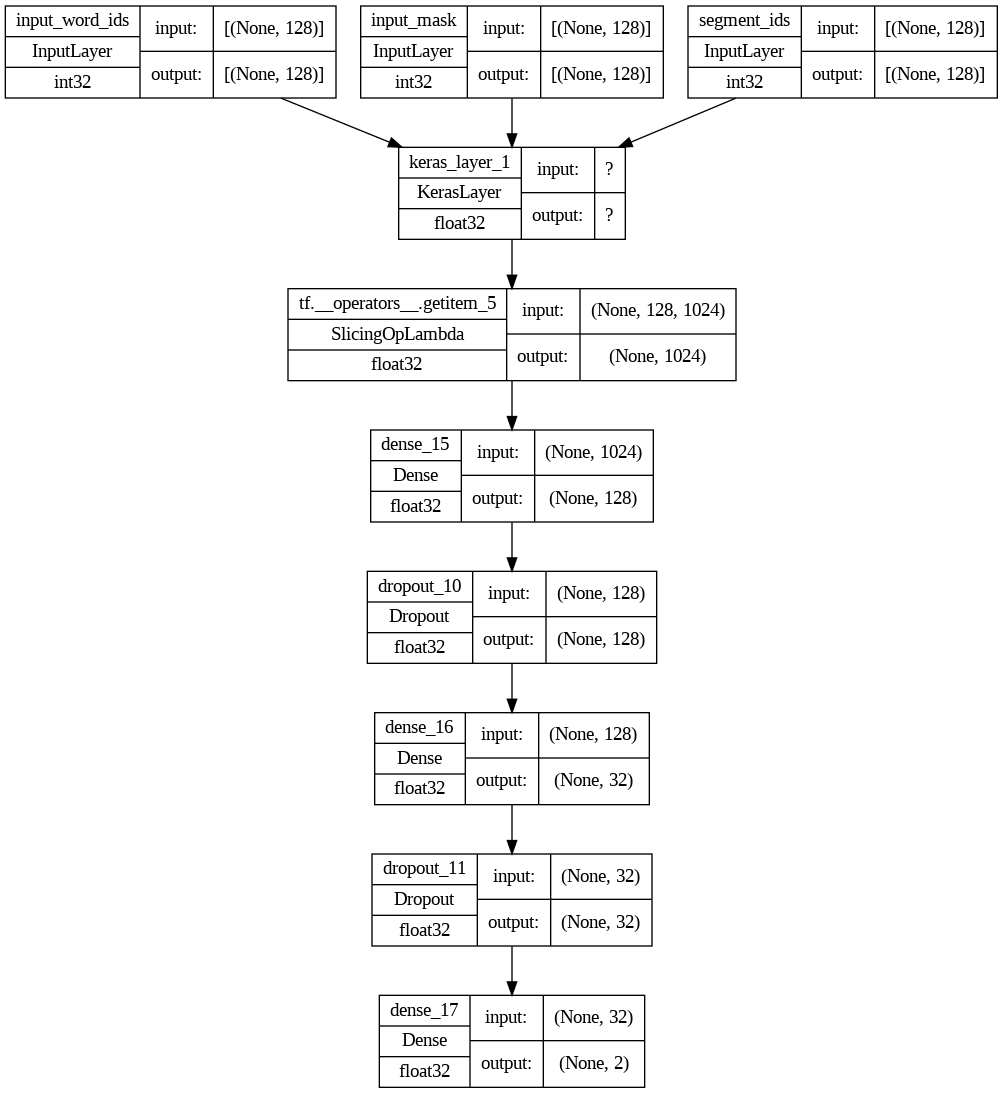

In [193]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [ ]:
!pip install livelossplot

In [126]:
from livelossplot import PlotLossesKeras
from livelossplot.outputs import MatplotlibPlot

In [127]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

In [194]:
filepath="/content/drive/MyDrive/Final_DLP/BERT_weights-improvement-{epoch:02d}_valloss{val_loss:.3f}.h5"
early_stop_patience = 5
reduce_lr_patience = 5
earlystopping = EarlyStopping(monitor = 'val_acc',
                              mode = 'max' ,
                              patience = early_stop_patience,
                              verbose = 1)
checkpoint = ModelCheckpoint(filepath,
                             save_weights_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1,
                             save_best_only=True,
                             )
liveplot = PlotLossesKeras(outputs=[MatplotlibPlot(cell_size=(6,2))])
callbacks_list = [earlystopping, checkpoint, liveplot]

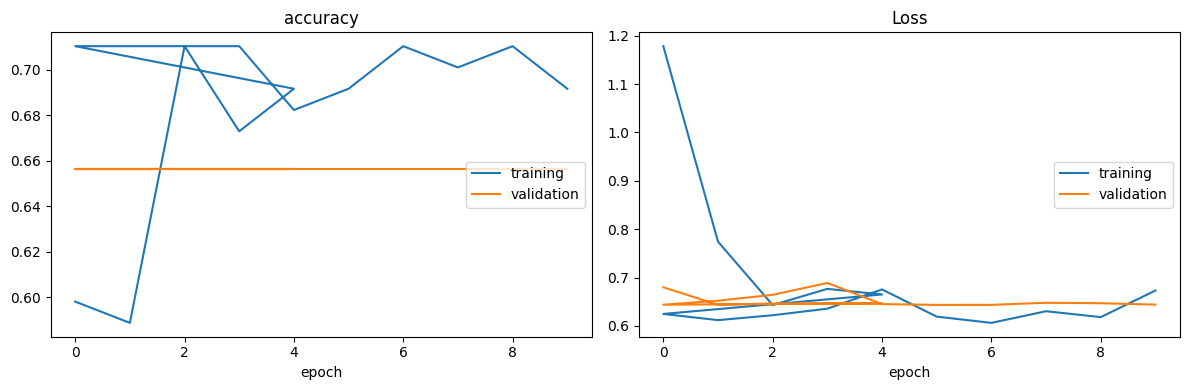

7/7 [==============================] - 3s 442ms/step - loss: 0.6732 - accuracy: 0.6916 - val_loss: 0.6441 - val_accuracy: 0.6562


In [196]:
#tain model
train_history = model.fit(
    train_input, train_labels,
    validation_data=(dev_input,dev_labels),
    batch_size=16,
    epochs=10,
    callbacks=callbacks_list

)

model.save('/content/drive/MyDrive/Final_DLP/best_model.h5')

In [133]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Final_DLP/best_model.h5",custom_objects={'KerasLayer':hub.KerasLayer})
#model = model.load_weights("/content/drive/MyDrive/Final_DLP/best_model.h5")

In [134]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 128)]                0         []                            
                                                                                                  
 keras_layer (KerasLayer)    [(None, 1024),               3335792   ['input_word_ids[0][0]',  

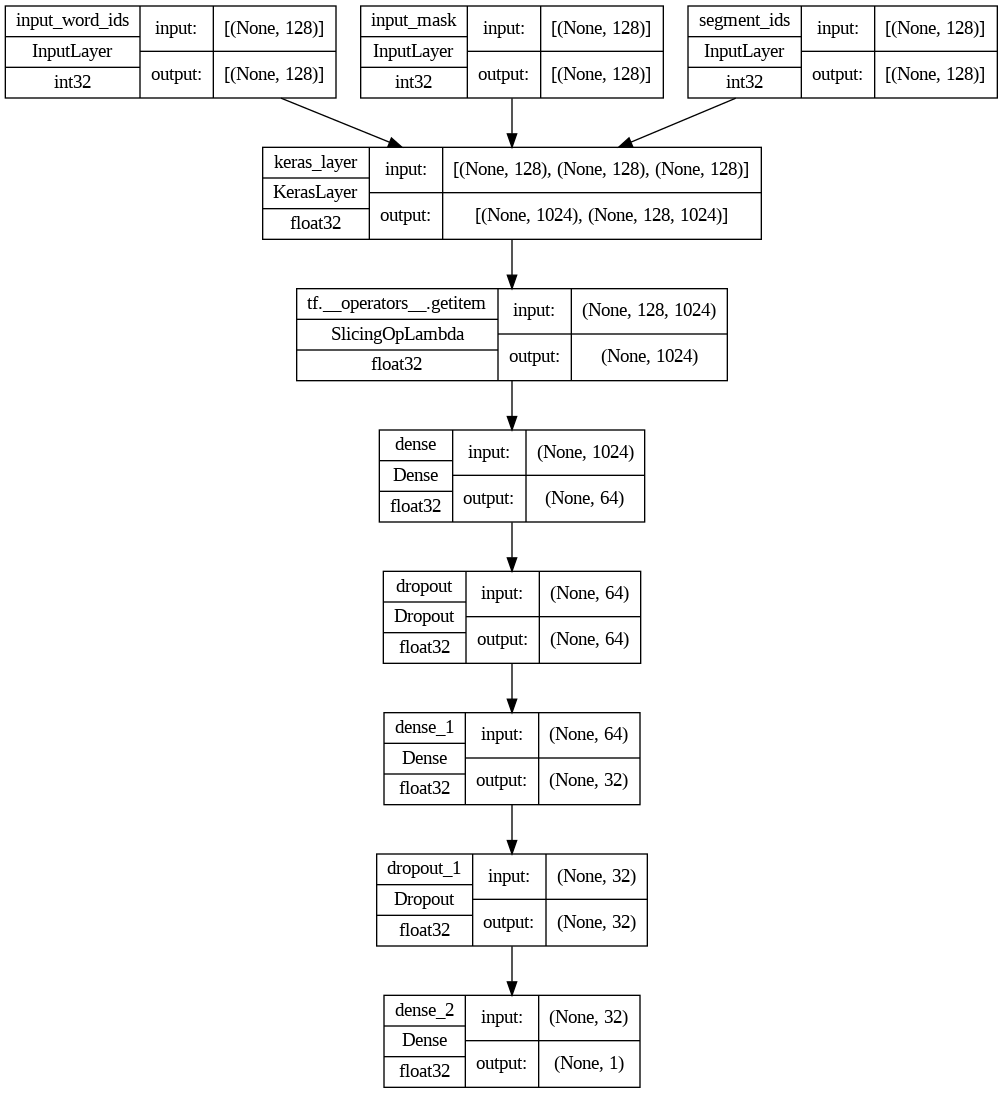

In [135]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [197]:
score = model.evaluate(test_input, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:',score[1] )

Test loss: 0.6156842708587646
Test accuracy: 0.695652186870575


In [198]:
%%time
test_pred = model.predict(test_input)

2/2 [==============================] - 2s 197ms/step
CPU times: user 1.61 s, sys: 34.2 ms, total: 1.65 s
Wall time: 1.67 s


In [199]:
test_pred

array([[0.6729946 , 0.32700536],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700542],
       [0.67299455, 0.32700542],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700542],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700542],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700542],
       [0.67299455, 0.32700542],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700542],
       [0.6729946 , 0.32700536],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700548],
       [0.6729946 , 0.32700536],
       [0.67299455, 0.32700548],
       [0.67299455, 0.32700542],
       [0.67299455, 0.32700542],
       [0.67299455, 0.32700548],
       [0.

In [215]:
y_predict = []
for i in range(len(test_pred)):
  y_pred = np.argmax(test_pred[i])
  y_predict.append(y_pred)

y_test = []
for i in range(len (test_labels)):
  y_label = np.argmax(test_labels[i])
  y_test.append(y_label)

In [218]:
from sklearn.metrics import accuracy_score,classification_report,  ConfusionMatrixDisplay, confusion_matrix

In [211]:
accuracy_score(y_test, y_predict)

0.6956521739130435

In [212]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.70      1.00      0.82        32
           1       0.00      0.00      0.00        14

    accuracy                           0.70        46
   macro avg       0.35      0.50      0.41        46
weighted avg       0.48      0.70      0.57        46



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


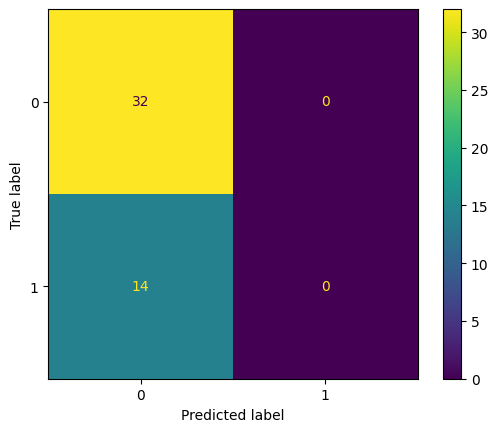

In [219]:

cm = confusion_matrix(y_test, y_predict)
cm_display = ConfusionMatrixDisplay(cm).plot()
ax = sns.heatmap(cm, annot = True, xticklabels = y_predict, yticklabels = y_test, linewidth=.5, )
ax.set(xlabel='Predict',ylabel='Actual')